# LDDMM: how to estimate a deterministic atlas?

This is analog to a registration problem for multiple meshes.

For registration between two meshes check [LDDMM: how to register a mesh to a template?](./lddmm_register_mesh_template.ipynb).

In [1]:
import shutil
from pathlib import Path

import numpy as np
import pyvista as pv

import polpo.lddmm as plddmm
import polpo.preprocessing.dict as ppdict
import polpo.utils as putils
from polpo.plot.pyvista import RegisteredMeshesGifPlotter
from polpo.preprocessing.load.pregnancy.jacobs import MeshLoader
from polpo.preprocessing.mesh.io import DictMeshWriter
from polpo.preprocessing.mesh.registration import RigidAlignment

No CUDA runtime is found, using CUDA_HOME='/usr'


In [2]:
DEBUG = False
RECOMPUTE = False
STATIC_VIZ = True

if STATIC_VIZ:
    pv.set_jupyter_backend("static")

In [3]:
OUTPUTS_DIR = Path("results") / "atlas_example"
ATLAS_DIR = OUTPUTS_DIR / "atlas"

if OUTPUTS_DIR.exists() and RECOMPUTE:
    shutil.rmtree(OUTPUTS_DIR)


OUTPUTS_DIR.mkdir(exist_ok=True, parents=True)

## Loading meshes

In [4]:
subject_id = "01"
session_subset = [1, 2, 3] if DEBUG else None


path2mesh = MeshLoader(
    subject_subset=[subject_id],
    session_subset=session_subset,
    struct_subset=["L_Hipp"],
    as_mesh=True,
)

pipe = path2mesh + ppdict.ExtractUniqueKey(nested=True)

meshes = pipe()

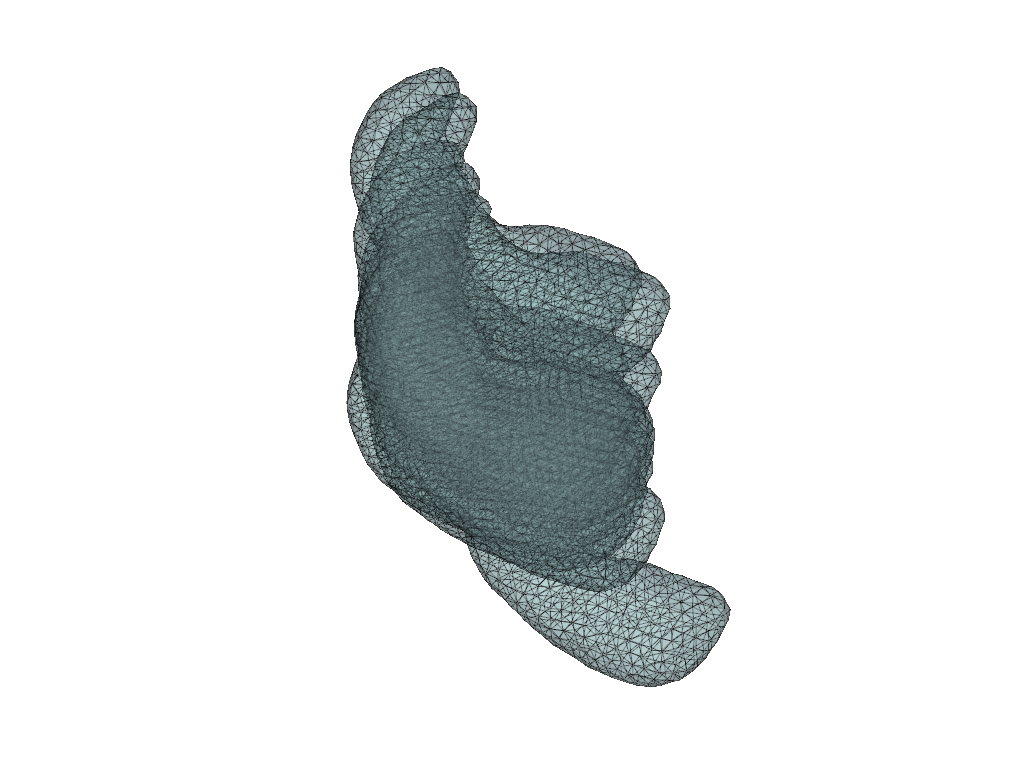

In [5]:
pl = pv.Plotter(border=False)

for mesh in meshes.values():
    pl.add_mesh(mesh, show_edges=True, opacity=0.5)

pl.show()

In [6]:
prep_pipe = RigidAlignment(max_iterations=500)

meshes = prep_pipe(meshes)

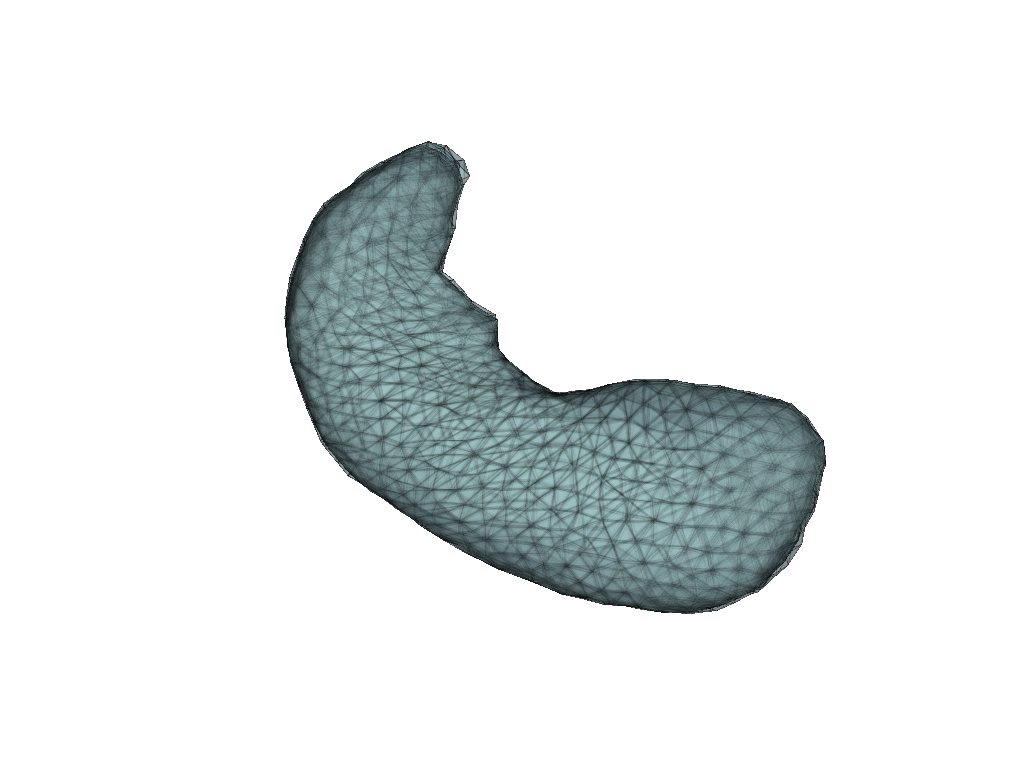

In [7]:
pl = pv.Plotter(border=False)

for mesh in meshes.values():
    pl.add_mesh(mesh, show_edges=True, opacity=0.5)

pl.show()

## Deterministic atlas

Save meshes in `vtk` format (as required by `deformetrica`).

In [8]:
meshes_writer = DictMeshWriter(dirname=OUTPUTS_DIR, ext="vtk")

dataset = meshes_writer(meshes)

Use LDDMM to estimate the atlas.

In [9]:
kernel_width = 10.0  # NB: influences the number of cp
registration_kwargs = dict(
    kernel_width=kernel_width,
    regularisation=1,
    max_iter=2000,
    freeze_control_points=False,
    metric="varifold",
    attachment_kernel_width=2.0,
    tol=1e-10,
)

if not ATLAS_DIR.exists():
    plddmm.learning.estimate_deterministic_atlas(
        targets=dataset,
        output_dir=ATLAS_DIR,
        initial_step_size=1e-1,
        **registration_kwargs,
    )

## Visualization

Visualize the results.

In [10]:
cp = plddmm.io.load_cp(ATLAS_DIR)
momenta = plddmm.io.load_momenta(ATLAS_DIR)
template = plddmm.io.load_template(ATLAS_DIR, as_pv=True)

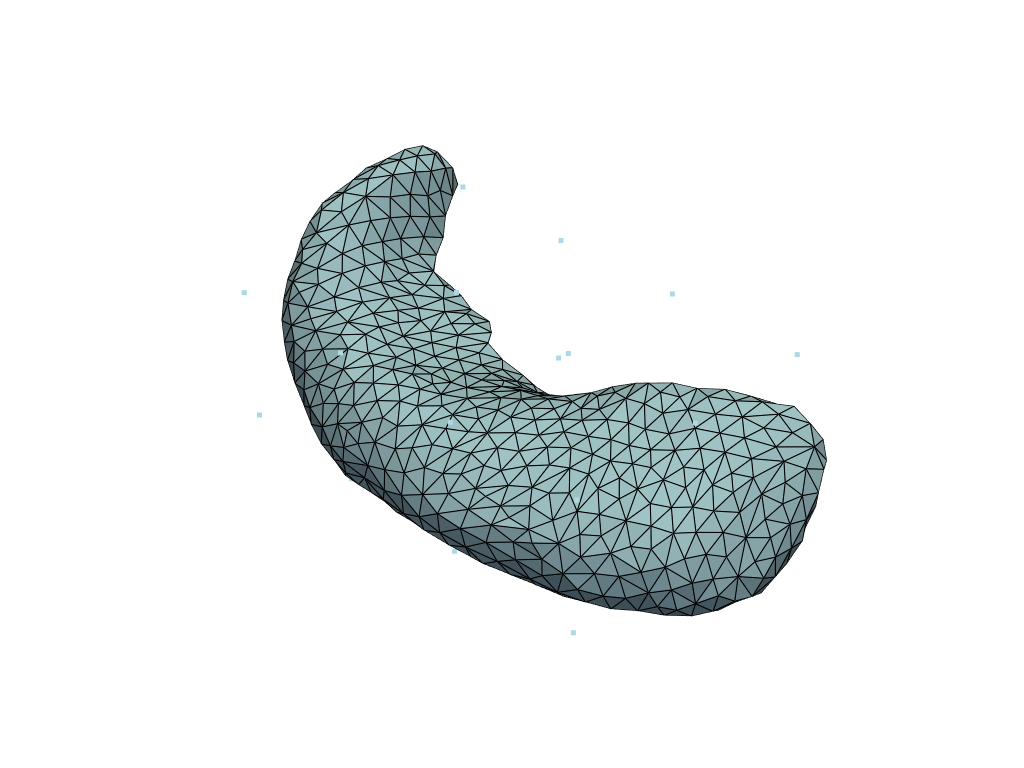

In [11]:
pl = pv.Plotter()

pl.add_mesh(template, show_edges=True)

pl.add_mesh(pv.PolyData(cp))

pl.show()

Visualize the reconstruction errors.

In [12]:
rec_meshes = plddmm.io.load_deterministic_atlas_reconstructions(ATLAS_DIR, as_pv=True)

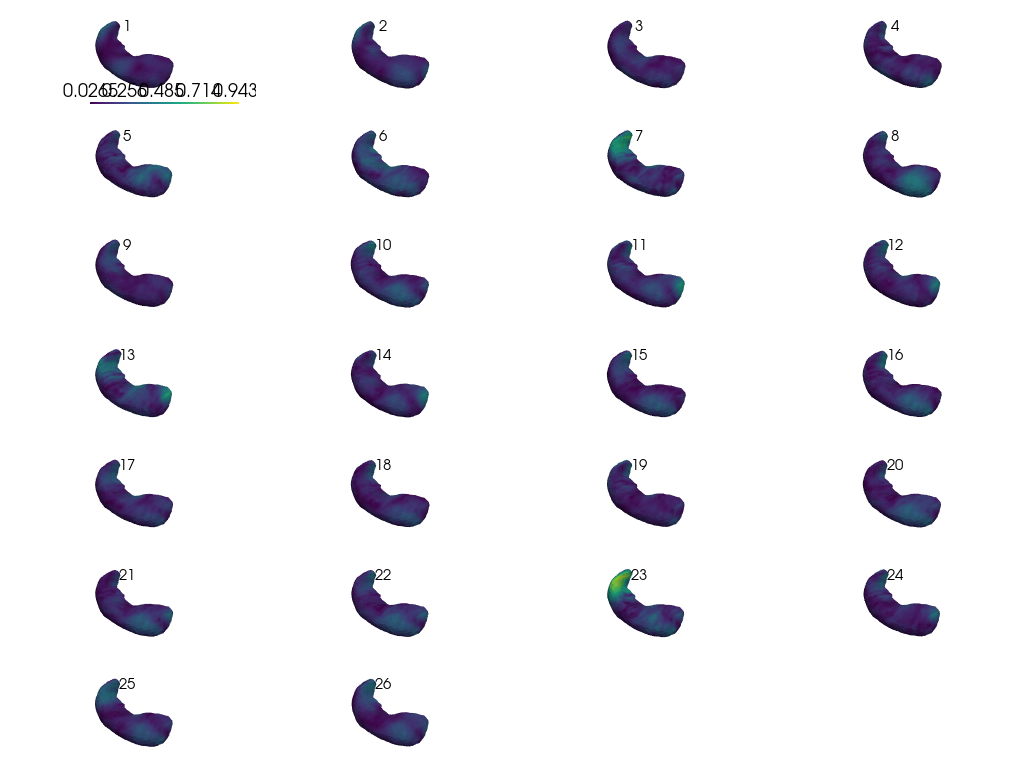

In [13]:
plot_shape = putils.plot_shape_from_n_plots(len(meshes), n_axis=4)

pl = pv.Plotter(shape=plot_shape, border=False)

for index, key in enumerate(meshes.keys()):
    mesh, rec_mesh = meshes[key], rec_meshes[key]
    pl.subplot(*putils.plot_index_to_shape(index, plot_shape[1]))

    # NB: assumes meshes are registered
    euc_res = np.linalg.norm(mesh.points - rec_mesh.points, axis=-1)
    pl.add_mesh(rec_mesh, scalars=euc_res)
    pl.add_title(str(key), font_size=8)

pl.show()

Visualize the flow from the template to each of the meshes.

In [14]:
flows = plddmm.io.load_deterministic_atlas_flows(ATLAS_DIR, as_pv=True)

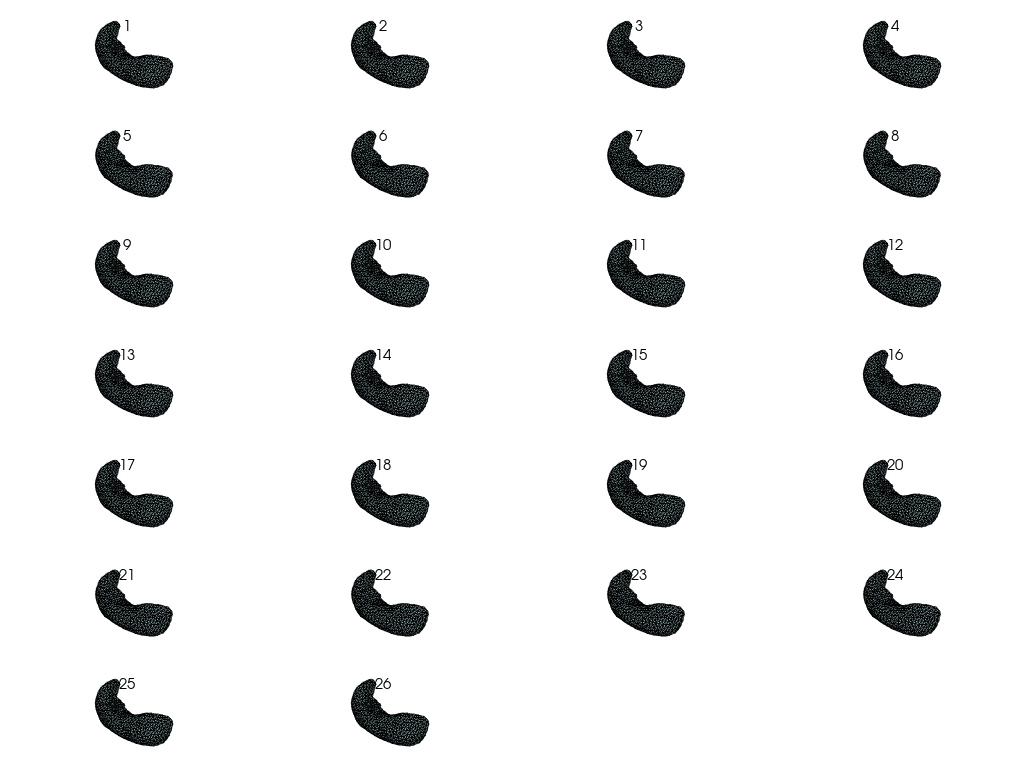

In [15]:
pl = RegisteredMeshesGifPlotter(
    shape=putils.plot_shape_from_n_plots(len(meshes), n_axis=4),
    fps=10,
    border=False,
    off_screen=True,
    notebook=False,
    subtitle=True,
)

pl.add_meshes(ppdict.DictListSwapper()(flows))
pl.close()

pl.show()

## Further reading

* [LDDMM: how to register a mesh to a template?](./lddmm_register_mesh_template.ipynb)

* [LDDMM: how to do regression?](./lddmm_regression.ipynb)

* [LDDMM: how To Bring Deformations from Subject-Specific Atlases Into the Tangent Space at the Global Atlas](./lddmm_regression_across_subjects.ipynb)